In [1]:

## Imports
import torch
import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import random

## Set styling parameters for figures
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

## Set random seed for numpy and Torch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Check CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            device = torch.device("cpu")
            print("Running on CPU")

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5)


        self.linear1 = nn.Linear(in_features=n_hidden, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=1)

    
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear1(last_time_step)
        y_pred = self.linear2(y_pred)
        y_pred = self.linear3(y_pred)
        return y_pred

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on the GPU


In [5]:
def train_model(model):
   

    loss_fn = torch.nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        
    num_epochs =5

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
              
    model = model.to(device)
    
    
    for j in range(len(batches)): 
        print("Batch num: ", j)
        train_data, train_labels, test_data, test_labels = get_batches(j)       


        for t in range(num_epochs):
        
            model.reset_hidden_state()

            y_pred = model(train_data)

            loss = loss_fn(y_pred.float(), train_labels)

        
            
            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(train_data)
                    test_loss = loss_fn(y_test_pred.float(), train_labels)
                test_hist[t] = test_loss.item()

                if t % 10 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
            elif t % 10 == 0:
                  print(f'Epoch {t} train loss: {loss.item()}')


            train_hist[t] = loss.item()

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
    
    return model.eval(), train_hist, test_hist, optimizer, t, loss_fn

In [6]:
data = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/mean_force_data.csv")
#data = data[:80000]
main_seq = data


In [7]:
n=1000
batches = [data[i:i + n] for i in range(0, len(data), n)]
print(len(batches))

random.seed(42)
random.shuffle(batches)

display(batches[0])

test_batches = batches[70:]
batches = batches[:70]
print(len(batches))

79


,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5,force_mean
49000,1.884678,-1.026276,2.121598,-2.659940,-1.566119,1.763162,2.234716
49001,1.883263,-1.027091,2.123219,-2.660933,-1.566131,1.767244,2.230994
49002,1.880589,-1.028626,2.126567,-2.662585,-1.566095,1.775085,2.228869
49003,1.876715,-1.030663,2.131596,-2.665135,-1.566143,1.786686,2.226343
49004,1.871546,-1.033349,2.137718,-2.668607,-1.566119,1.802022,2.223548
...,...,...,...,...,...,...,...
49995,2.209910,-0.947392,2.000317,-2.571483,-1.555994,0.472016,3.180868
49996,2.209910,-0.947692,2.000618,-2.571304,-1.555994,0.475947,3.172925
49997,2.209910,-0.947584,2.000125,-2.570873,-1.555994,0.480549,3.161131
49998,2.210006,-0.947644,2.000209,-2.570897,-1.555994,0.484312,3.151508


70


In [8]:
print(test_batches[1])

        joint_0   joint_1   joint_2   joint_3   joint_4   joint_5  force_mean
69000  2.212992 -1.054126  2.175693 -2.666045 -1.606355  2.157130    8.257141
69001  2.211493 -1.054149  2.175681 -2.666153 -1.606344  2.155538    8.258202
69002  2.211505 -1.054161  2.175693 -2.666069 -1.606380  2.155526    8.260476
69003  2.211529 -1.054149  2.175693 -2.666117 -1.606367  2.155550    8.257928
69004  2.211541 -1.054138  2.175716 -2.666117 -1.606344  2.155526    8.250727
...         ...       ...       ...       ...       ...       ...         ...
69995  1.830457 -0.669128  1.361881 -2.264226 -1.572985  3.145527    3.577663
69996  1.831909 -0.669056  1.361917 -2.264154 -1.572997  3.147850    3.590720
69997  1.831849 -0.669116  1.362049 -2.264441 -1.573033  3.147802    3.602425
69998  1.831837 -0.669140  1.362206 -2.264537 -1.572985  3.147754    3.613756
69999  1.831825 -0.669044  1.362061 -2.264322 -1.572985  3.147767    3.627199

[1000 rows x 7 columns]


In [9]:
featuresscaler2 = batches[0].iloc[:,-1]

x_scaler = MinMaxScaler(feature_range=(-1, 1))

featuresscaler2 = np.asarray(featuresscaler2)
featuresscaler2 = featuresscaler2.reshape(-1,1)
x_scaler = x_scaler.fit(featuresscaler2)

features2 =x_scaler.transform(featuresscaler2)
targets2 = features2[:,-1].reshape(-1,1)

preds2 = targets2

predicted_cases2 = x_scaler.inverse_transform(preds2).reshape(-1,1)

print("original",batches[0].iloc[:5,-1])
print("scaled",targets2[:5])
print("Unscaled",predicted_cases2[:5])

original 49000    2.234716
49001    2.230994
49002    2.228869
49003    2.226343
49004    2.223548
Name: force_mean, dtype: float64
scaled [[-0.43834195]
 [-0.44074578]
 [-0.44211808]
 [-0.44374971]
 [-0.44555487]]
Unscaled [[2.2347157 ]
 [2.23099402]
 [2.22886939]
 [2.22634325]
 [2.22354845]]


In [15]:
def get_test_batch(batch_number):
    
#     featuresscaler = batches[0]
#     jim = featuresscaler.iloc[:,-1]# capture a seq for display on prediction chart.
#     scaler1 = MinMaxScaler(feature_range=(-1, 1))

#     scaler1 = scaler1.fit(featuresscaler)
#     features = scaler1.transform(featuresscaler)
#     targets = features[:,-1].reshape(-1,1)

    features = test_batches[batch_number].reset_index(drop=True)
    jim = features.iloc[:,-1]
    
    targets = features.iloc[:,-1]
    features = features[['joint_0', 'joint_2', 'joint_4', 'joint_5', 'force_mean']]
    features = np.asarray(features)
    
    targets = np.asarray(targets)
    targets - targets.reshape(-1,1)
    
    

    


    def test_create_sequences(seq_length):
        xs = []
        ys = []

        for i in range(len(features)-seq_length):
            x = features[i:(i+seq_length)]
            #print(i,(i+seq_length))
            y = targets[i+seq_length]
            #print(i+seq_length+1)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    seq_length = 250

    Xtest, ytest = test_create_sequences(seq_length)

    Xtest = torch.cuda.FloatTensor(Xtest)
    ytest = torch.cuda.FloatTensor(ytest)

    return(Xtest, ytest, jim)
  

In [11]:
def get_batches(batch_num):  
    
    data = batches[batch_num].reset_index(drop=True)

    ################################################

    features_scaler = data  

#     scaler = MinMaxScaler(feature_range=(-1, 1))

#     scaler = scaler.fit(features_scaler)
#     features = scaler.transform(features_scaler)
#     targets = features[:,-1].reshape(-1,1)
    ###################################################

    
    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5', 'force_mean']]
    features = np.asarray(features)
    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)
    features = np.asarray(features)
    
    
    
    test_data_size = 500

    X_train = features[:-test_data_size]
    X_test = features[-test_data_size:]
    y_train = targets[:-test_data_size]
    y_test = targets[-test_data_size:]

    ####################################################

    def train_create_sequences(seq_length):
        xs = []
        ys = []

        for i in range(len(X_train)-seq_length):
            x = X_train[i:(i+seq_length)]
            #print(i,(i+seq_length))
            y = y_train[i+seq_length]
            #print(i+seq_length+1)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    def test_create_sequences(seq_length):
        xs = []
        ys = []

        for i in range(len(X_test)-seq_length):
            x = X_test[i:(i+seq_length)]
            #print(i,(i+seq_length))
            y = y_test[i+seq_length]
            #print(i+seq_length+1)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    #######################################################


    X_train, y_train = train_create_sequences(seq_length)
    X_test, y_test = test_create_sequences(seq_length)

    X_train = torch.cuda.FloatTensor(X_train)
    y_train = torch.cuda.FloatTensor(y_train)
    X_test = torch.cuda.FloatTensor(X_test)
    y_test = torch.cuda.FloatTensor(y_test)
    
    return(X_train, y_train, X_test, y_test)

In [12]:
seq_length = 250

model = CoronaVirusPredictor(
      n_features=5, 
      n_hidden=256, 
      seq_len=seq_length, 
      n_layers=2 
    )

model, train_hist, test_hist, optimizer, epochs, loss = train_model(model)

Running on the GPU
Batch num:  0
Epoch 0 train loss: 9.803757667541504 test loss: 9.804120063781738
Batch num:  1
Epoch 0 train loss: 22.905946731567383 test loss: 22.909404754638672
Batch num:  2
Epoch 0 train loss: 3.43041729927063 test loss: 3.4262535572052
Batch num:  3
Epoch 0 train loss: 3.471130132675171 test loss: 3.4694104194641113
Batch num:  4
Epoch 0 train loss: 48.61207962036133 test loss: 48.59947204589844
Batch num:  5
Epoch 0 train loss: 1.5073658227920532 test loss: 1.5058656930923462
Batch num:  6
Epoch 0 train loss: 333.39056396484375 test loss: 333.2960510253906
Batch num:  7
Epoch 0 train loss: 0.35788753628730774 test loss: 0.3432646095752716
Batch num:  8
Epoch 0 train loss: 13.863481521606445 test loss: 13.909542083740234
Batch num:  9
Epoch 0 train loss: 5.428773880004883 test loss: 5.448355674743652
Batch num:  10
Epoch 0 train loss: 5.810503005981445 test loss: 5.821822643280029
Batch num:  11
Epoch 0 train loss: 1.9518123865127563 test loss: 1.93822908401489

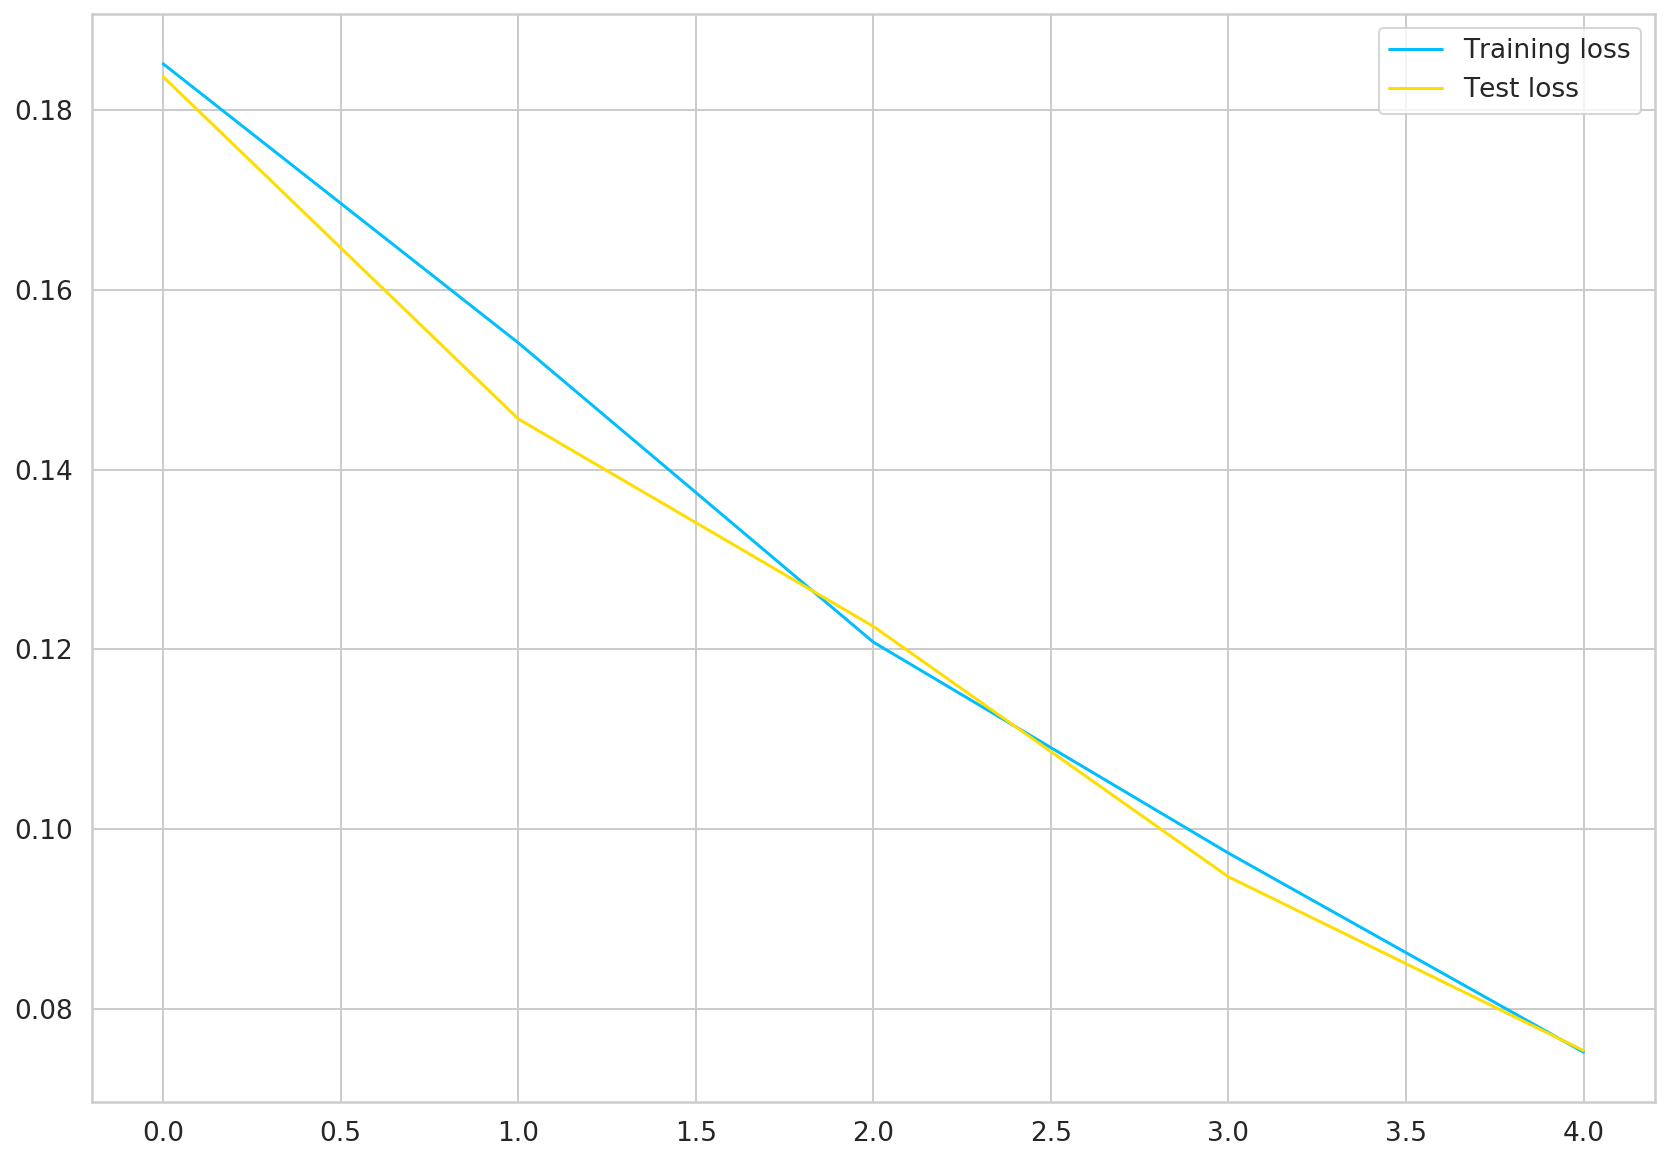

In [13]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();

In [16]:
Xtest, ytest, jim = get_test_batch(3)

with torch.no_grad():
    test_seq = Xtest[:1] # input first sequence from trajectory/batch
    preds = [] # create a list to store predictions.
    for i in range(len(Xtest)): # for each sequence i in the trajectory,
        y_test_pred = model(test_seq).to(device) # send sequence to model,
        pred = torch.flatten(y_test_pred).item() # reshape the model output,
        preds.append(pred) # and append to the list of predictions - preds.
        new_seq = Xtest[i] # Change sequence to the next one in the list.
        test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1) # change sequence to a torch Tensor
   

(79000, 7)
750


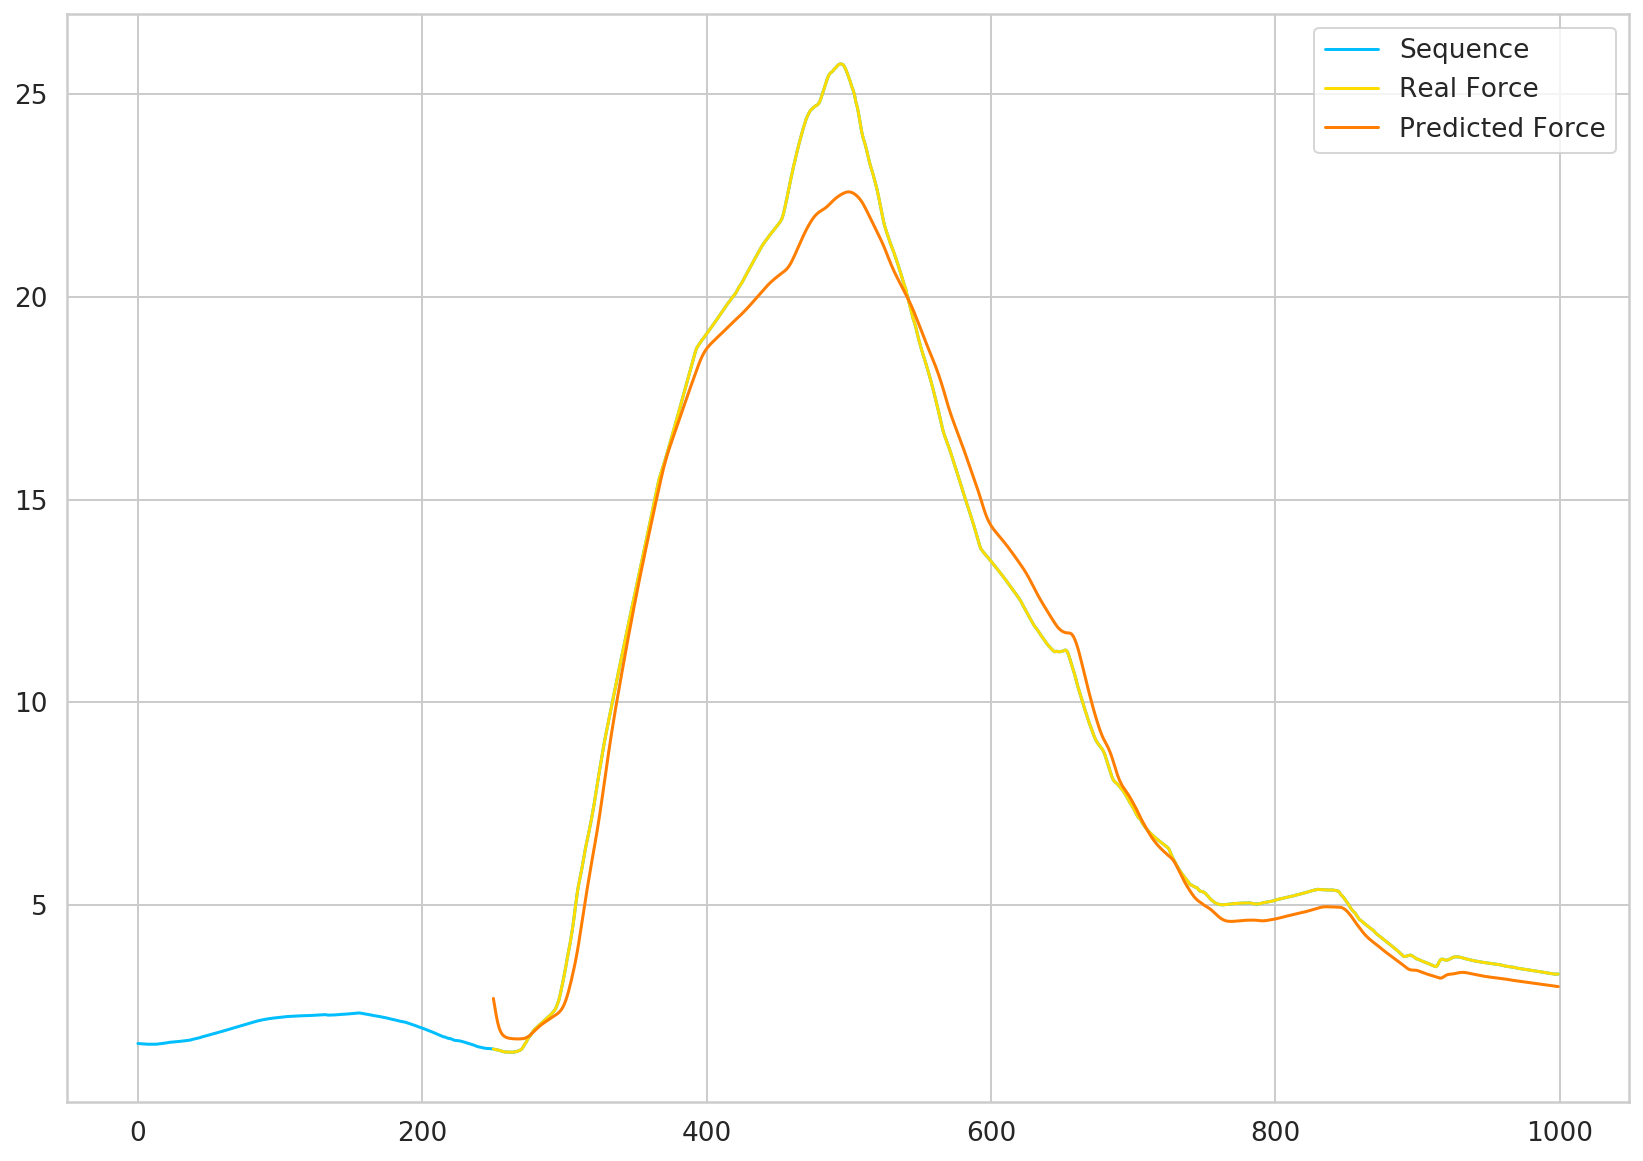

In [17]:
preds = np.asarray(preds)
preds = np.reshape(preds, (-1,1))

ytest2 = ytest.cpu()
ytest2 = np.asarray(ytest2)
ytest2 = np.reshape(ytest2, (-1,1))

predicted_cases = preds
true_cases = ytest2


print(main_seq.shape)
seq = pd.DataFrame(jim)
seq = seq.reset_index(drop=True)
#main_seq_reset = main_seq.reset_index(drop=True)

plt.plot(seq,label='Sequence')

print(len(predicted_cases))
plt.plot(seq.index[len(seq[:250]):1000], true_cases[:,-1], label='Real Force')

plt.plot(seq.index[len(seq[:250]):1000], predicted_cases[:,-1], label='Predicted Force')


# plt.plot(main_seq_reset.iloc[:1000,-1],label='Sequence')

# print(len(predicted_cases))
# plt.plot(main_seq_reset.index[len(seq[:550]):1000], true_cases, label='Real Force')

# plt.plot(main_seq_reset.index[len(seq[:550]):1000], predicted_cases, label='Predicted Force')

# plt.plot(true_cases)
# plt.plot(predicted_cases)

plt.legend();

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(data)

all_data = scaler.transform(data)

all_data.shape

In [ ]:
X_all, y_all = train_create_sequences( seq_length)

X_all = torch.cuda.FloatTensor(X_all)
y_all = torch.cuda.FloatTensor(y_all)

model = CoronaVirusPredictor(
  n_features=7, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 5

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
    
        y_test_pred = model(test_seq).to(device)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        print(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1)
        

In [ ]:
predicted_cases = scaler.inverse_transform(preds).flatten()
print(predicted_cases.shape)
                                           
# print(np.shape(preds))
# preds = np.asarray(preds)
# preds = preds.reshape([5,7])
# print(np.shape(preds))

# predicted_cases = scaler.inverse_transform(preds)                                           

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

